In [1]:
# Imports & display options
import io, zipfile, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)
plt.rcParams["figure.figsize"] = (12, 6)


In [2]:
# Upload file (CSV or ZIP) & load DataFrame
from google.colab import files

uploaded = files.upload()
assert len(uploaded) >= 1, "No file uploaded."

fname = next(iter(uploaded))

def load_dataframe_from_any(fname: str) -> pd.DataFrame:
    if fname.lower().endswith(".csv"):
        return pd.read_csv(io.BytesIO(uploaded[fname]), low_memory=False, on_bad_lines="skip", encoding="utf-8")
    if fname.lower().endswith(".zip"):
        zf = zipfile.ZipFile(io.BytesIO(uploaded[fname]))
        csv_members = [n for n in zf.namelist() if n.lower().endswith(".csv")]
        assert len(csv_members) > 0, "ZIP does not contain a CSV."
        with zf.open(csv_members[0]) as f:
            return pd.read_csv(f, low_memory=False, on_bad_lines="skip", encoding="utf-8")
    return pd.read_csv(fname, low_memory=False, on_bad_lines="skip", encoding="utf-8")

df_raw = load_dataframe_from_any(fname).copy()
df = df_raw.copy()

print("Loaded shape:", df.shape)
df.head(3)


Saving global_air_quality_dataset.csv to global_air_quality_dataset.csv
Loaded shape: (3660, 13)


,Date,City,Country,AQI,PM2.5 (µg/m³),PM10 (µg/m³),NO2 (ppb),SO2 (ppb),CO (ppm),O3 (ppb),Temperature (°C),Humidity (%),Wind Speed (m/s)
0,2024-01-01,New York,USA,38,120.0,182.9,24.3,26.0,9.10,153.3,18.6,40,13.2
1,2024-01-01,Los Angeles,USA,280,38.4,46.9,41.8,34.7,3.78,190.7,-2.2,59,9.5
2,2024-01-01,London,UK,117,168.1,34.3,81.5,8.2,3.67,105.4,36.3,62,3.4


In [3]:
# Clean column names & auto-detect key columns
def normalize(name: str) -> str:
    return re.sub(r"[^a-z0-9]+", "", name.strip().lower())

norm2orig = {}
for c in df.columns:
    norm2orig[normalize(c)] = c

# Convenience search
def find_first(possible_keys):
    for key in possible_keys:
        key_norm = normalize(key)
        for n, orig in norm2orig.items():
            if n == key_norm:
                return orig
        # contains match (e.g., "measurementdate" contains "date")
        for n, orig in norm2orig.items():
            if key_norm in n:
                return orig
    return None

CITY_COL    = find_first(["city", "town", "location", "urbanarea"])
COUNTRY_COL = find_first(["country", "nation"])
DATE_COL    = find_first(["date", "datetime", "day"])
YEAR_COL    = find_first(["year"])
MONTH_COL   = find_first(["month"])

AQI_COL     = find_first(["aqi", "airqualityindex", "air_quality_index"])

cand_cols = ["pm2.5", "pm25", "pm_2_5", "pm10", "no2", "so2", "co", "o3", "ozone",
             "no", "nox", "nh3", "benzene", "toluene", "xylene",
             "temperature", "temp", "humidity", "windspeed", "wind_speed", "dewpoint", "dew_point"]
POLLUTANT_COLS = []
for k in cand_cols:
    c = find_first([k])
    if c and c not in POLLUTANT_COLS:
        POLLUTANT_COLS.append(c)

print("Detected columns:")
print("  City:", CITY_COL)
print("  Country:", COUNTRY_COL)
print("  Date:", DATE_COL, "| Year:", YEAR_COL, "| Month:", MONTH_COL)
print("  AQI:", AQI_COL)
print("  Pollutants/Meteo:", POLLUTANT_COLS)


Detected columns:
  City: City
  Country: Country
  Date: Date | Year: None | Month: None
  AQI: AQI
  Pollutants/Meteo: ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO2 (ppb)', 'SO2 (ppb)', 'Country', 'O3 (ppb)', 'Temperature (°C)', 'Humidity (%)', 'Wind Speed (m/s)']


In [4]:
# Basic inspection
print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes)
print("\nMissing values (top 20):\n", df.isna().sum().sort_values(ascending=False).head(20))
display(df.head(10))


Shape: (3660, 13)

Dtypes:
 Date                 object
City                 object
Country              object
AQI                   int64
PM2.5 (µg/m³)       float64
PM10 (µg/m³)        float64
NO2 (ppb)           float64
SO2 (ppb)           float64
CO (ppm)            float64
O3 (ppb)            float64
Temperature (°C)    float64
Humidity (%)          int64
Wind Speed (m/s)    float64
dtype: object

Missing values (top 20):
 Date                0
City                0
Country             0
AQI                 0
PM2.5 (µg/m³)       0
PM10 (µg/m³)        0
NO2 (ppb)           0
SO2 (ppb)           0
CO (ppm)            0
O3 (ppb)            0
Temperature (°C)    0
Humidity (%)        0
Wind Speed (m/s)    0
dtype: int64


,Date,City,Country,AQI,PM2.5 (µg/m³),PM10 (µg/m³),NO2 (ppb),SO2 (ppb),CO (ppm),O3 (ppb),Temperature (°C),Humidity (%),Wind Speed (m/s)
0,2024-01-01,New York,USA,38,120.0,182.9,24.3,26.0,9.10,153.3,18.6,40,13.2
1,2024-01-01,Los Angeles,USA,280,38.4,46.9,41.8,34.7,3.78,190.7,-2.2,59,9.5
2,2024-01-01,London,UK,117,168.1,34.3,81.5,8.2,3.67,105.4,36.3,62,3.4
3,2024-01-01,Beijing,China,197,96.8,35.4,18.5,39.4,9.51,92.8,29.9,32,1.8
4,2024-01-01,Delhi,India,187,76.2,226.8,46.9,17.2,1.02,68.4,9.9,55,3.3
5,2024-01-01,Paris,France,170,217.6,278.0,21.7,45.2,1.77,125.2,37.4,67,1.4
6,2024-01-01,Tokyo,Japan,177,16.1,296.5,9.5,46.0,3.75,103.4,15.5,43,1.8
7,2024-01-01,Sydney,Australia,164,42.0,81.8,26.1,18.4,5.48,79.9,-6.8,81,14.3
8,2024-01-01,São Paulo,Brazil,123,46.7,104.5,6.4,19.7,1.08,49.9,7.1,10,5.3
9,2024-01-01,Cairo,Egypt,241,103.6,217.9,74.4,16.4,1.25,190.9,37.5,23,14.0


In [5]:
# Parse/construct date & basic cleaning
if DATE_COL and DATE_COL in df.columns:
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce", utc=True)
elif YEAR_COL:
    y = pd.to_numeric(df[YEAR_COL], errors="coerce")
    if MONTH_COL:
        m = pd.to_numeric(df[MONTH_COL], errors="coerce").fillna(1).astype(int).clip(1, 12)
    else:
        m = 1
    df["__tmp_date__"] = pd.to_datetime({"year": y.astype("Int64"), "month": m, "day": 1}, errors="coerce", utc=True)
    DATE_COL = "__tmp_date__"

# Drop rows with invalid dates
if DATE_COL:
    df = df.dropna(subset=[DATE_COL])

# Convert AQI & pollutants to numeric
if AQI_COL:
    df[AQI_COL] = pd.to_numeric(df[AQI_COL], errors="coerce")

for c in POLLUTANT_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Remove obviously invalid AQI values (e.g., negative)
if AQI_COL:
    df = df[(df[AQI_COL].isna()) | (df[AQI_COL] >= 0)]

if DATE_COL:
    df["Year"] = df[DATE_COL].dt.year
    df["Month"] = df[DATE_COL].dt.to_period("M").astype(str)

print("After cleaning shape:", df.shape)
df.head(5)


After cleaning shape: (3660, 15)


/tmp/ipython-input-3058444961.py:30: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["Month"] = df[DATE_COL].dt.to_period("M").astype(str)


,Date,City,Country,AQI,PM2.5 (µg/m³),PM10 (µg/m³),NO2 (ppb),SO2 (ppb),CO (ppm),O3 (ppb),Temperature (°C),Humidity (%),Wind Speed (m/s),Year,Month
0,2024-01-01 00:00:00+00:00,New York,NaN,38,120.0,182.9,24.3,26.0,9.10,153.3,18.6,40,13.2,2024,2024-01
1,2024-01-01 00:00:00+00:00,Los Angeles,NaN,280,38.4,46.9,41.8,34.7,3.78,190.7,-2.2,59,9.5,2024,2024-01
2,2024-01-01 00:00:00+00:00,London,NaN,117,168.1,34.3,81.5,8.2,3.67,105.4,36.3,62,3.4,2024,2024-01
3,2024-01-01 00:00:00+00:00,Beijing,NaN,197,96.8,35.4,18.5,39.4,9.51,92.8,29.9,32,1.8,2024,2024-01
4,2024-01-01 00:00:00+00:00,Delhi,NaN,187,76.2,226.8,46.9,17.2,1.02,68.4,9.9,55,3.3,2024,2024-01


In [6]:
# High-level summary
if CITY_COL:
    print("Unique cities:", df[CITY_COL].nunique())
    print("Top 10 cities by row count:")
    display(df[CITY_COL].value_counts().head(10))
if COUNTRY_COL:
    print("\nUnique countries:", df[COUNTRY_COL].nunique())
    print("Top 10 countries by row count:")
    display(df[COUNTRY_COL].value_counts().head(10))
if AQI_COL:
    print("\nAQI summary:")
    display(df[AQI_COL].describe())


Unique cities: 10
Top 10 cities by row count:


,count
City,
New York,366
Los Angeles,366
London,366
Beijing,366
Delhi,366
Paris,366
Tokyo,366
Sydney,366
São Paulo,366



Unique countries: 0
Top 10 countries by row count:


,count
Country,



AQI summary:


,AQI
count,3660.000000
mean,164.642077
std,78.571659
min,30.000000
25%,96.000000
50%,165.000000
75%,233.000000
max,300.000000


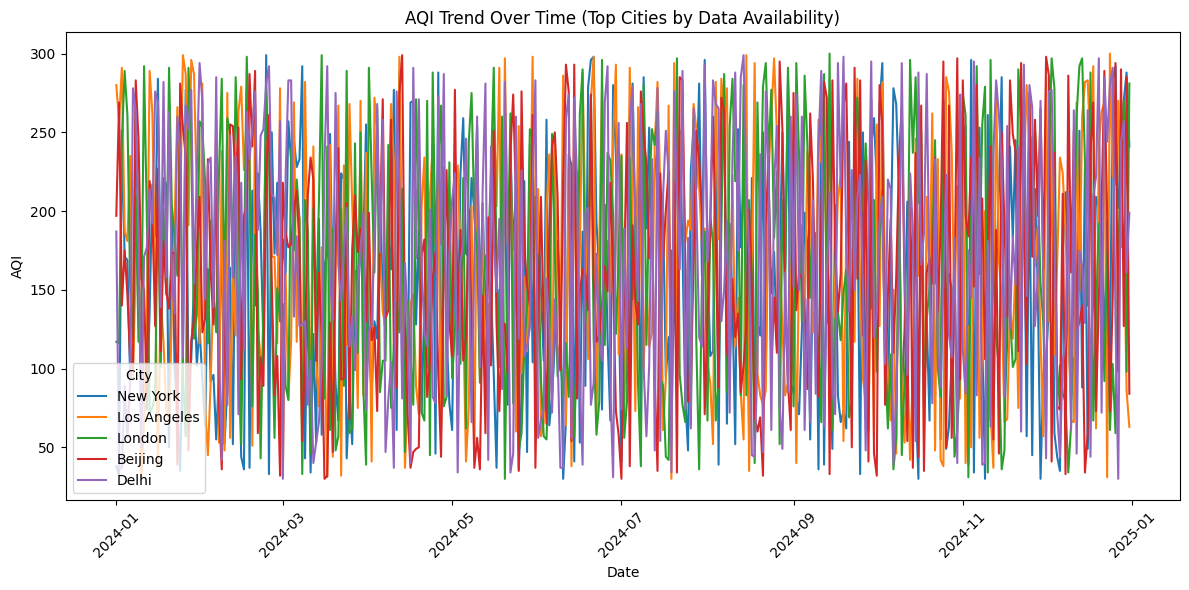

In [7]:
# AQI trend over time for top cities
if DATE_COL and AQI_COL and CITY_COL:
    top_cities = df[CITY_COL].value_counts().head(5).index.tolist()
    temp = df[df[CITY_COL].isin(top_cities)].sort_values(DATE_COL)
    plt.figure()
    sns.lineplot(data=temp, x=DATE_COL, y=AQI_COL, hue=CITY_COL, errorbar=None)
    plt.title("AQI Trend Over Time (Top Cities by Data Availability)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping city AQI trend plot (missing DATE/AQI/CITY columns).")


In [9]:
print("Using group column:", group_col)
print("Unique values in group column:", df[group_col].unique()[:20])
print("AQI sample:", df[AQI_COL].dropna().unique()[:20])


Using group column: Country
Unique values in group column: [nan]
AQI sample: [ 38 280 117 197 187 170 177 164 123 241  32 257 116 269  36 102 106 199
 114 271]


In [10]:
# Force group column to City instead of Country
group_col = CITY_COL

print("Now using group column:", group_col)
print("Unique values in group column:", df[group_col].unique()[:20])


Now using group column: City
Unique values in group column: ['New York' 'Los Angeles' 'London' 'Beijing' 'Delhi' 'Paris' 'Tokyo'
 'Sydney' 'São Paulo' 'Cairo']


/tmp/ipython-input-1327716551.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=temp, x=CITY_COL, y=AQI_COL, showfliers=False, palette="Set2")


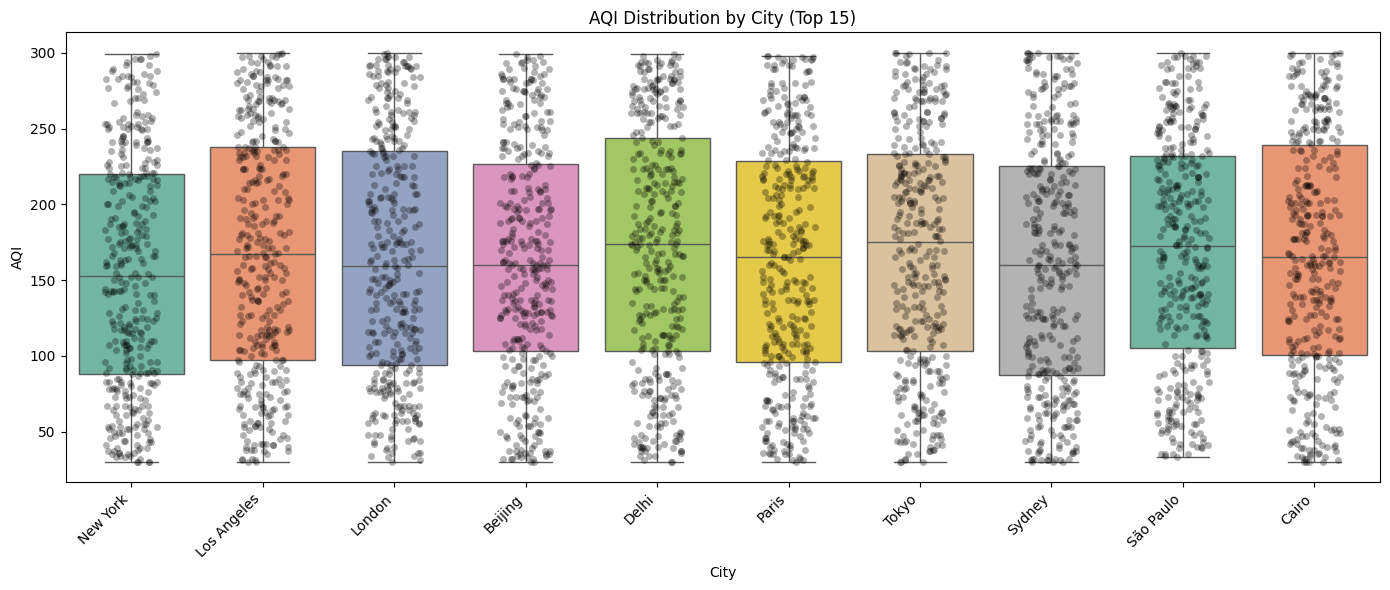

In [11]:
# AQI distribution by City
if AQI_COL and CITY_COL:
    # Pick only top 15 cities with most rows
    top_cities = df[CITY_COL].value_counts().head(15).index
    temp = df[df[CITY_COL].isin(top_cities)].dropna(subset=[AQI_COL])

    if temp.empty:
        print("No valid AQI data for selected cities.")
    else:
        plt.figure(figsize=(14,6))
        sns.boxplot(data=temp, x=CITY_COL, y=AQI_COL, showfliers=False, palette="Set2")
        sns.stripplot(data=temp, x=CITY_COL, y=AQI_COL, color="black", alpha=0.3, jitter=0.2)
        plt.title("AQI Distribution by City (Top 15)")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
else:
    print("Skipping plot (no AQI or City column).")


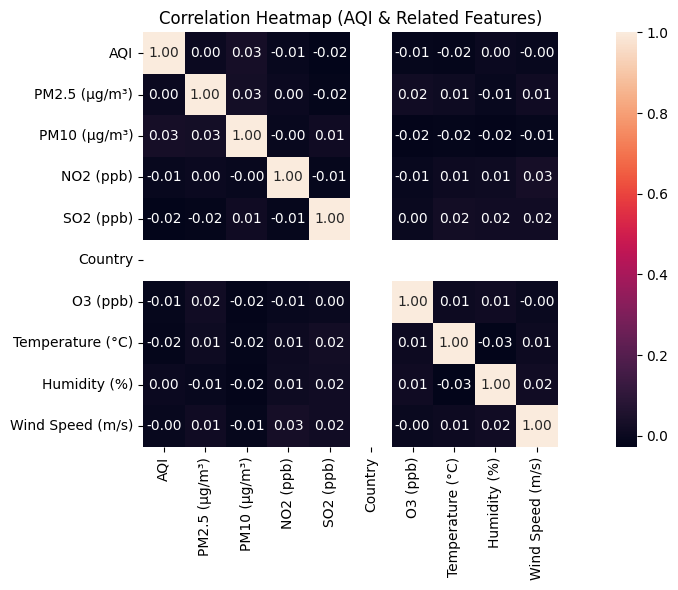

In [12]:
# Correlation heatmap for AQI + pollutant/meteorology features
num_cols = []
if AQI_COL: num_cols.append(AQI_COL)
for c in POLLUTANT_COLS:
    if c not in num_cols:
        num_cols.append(c)
num_df = df[num_cols].select_dtypes(include=[np.number])

if num_df.shape[1] >= 2:
    corr = num_df.corr(numeric_only=True)
    plt.figure()
    sns.heatmap(corr, annot=True, fmt=".2f", square=True)
    plt.title("Correlation Heatmap (AQI & Related Features)")
    plt.tight_layout()
    plt.show()
else:
    print("Skipping heatmap (need at least 2 numeric columns among AQI/pollutants).")


/tmp/ipython-input-4195228023.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_city = temp.groupby([pd.Grouper(key=DATE_COL, freq="M"), CITY_COL])[AQI_COL].mean().reset_index()


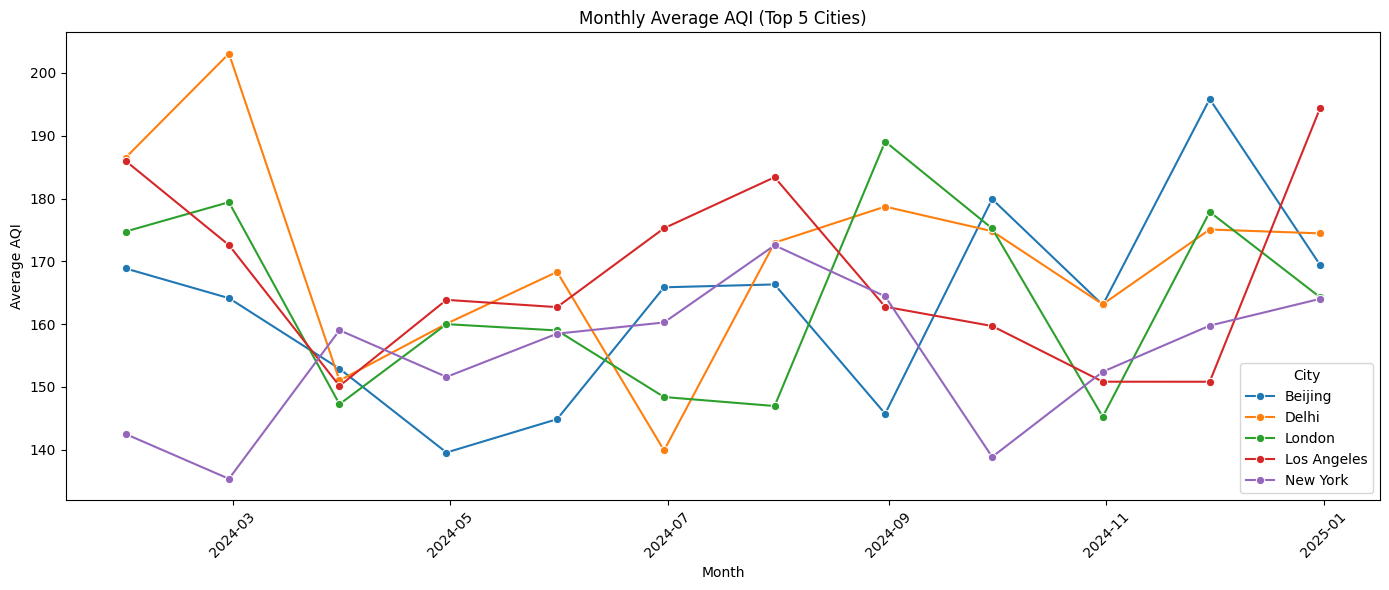

In [13]:
# Monthly Average AQI per City (Top 5)
if DATE_COL and AQI_COL and CITY_COL:
    top_cities = df[CITY_COL].value_counts().head(5).index
    temp = df[df[CITY_COL].isin(top_cities)].dropna(subset=[AQI_COL])
    monthly_city = temp.groupby([pd.Grouper(key=DATE_COL, freq="M"), CITY_COL])[AQI_COL].mean().reset_index()

    plt.figure(figsize=(14,6))
    sns.lineplot(data=monthly_city, x=DATE_COL, y=AQI_COL, hue=CITY_COL, marker="o")
    plt.title("Monthly Average AQI (Top 5 Cities)")
    plt.xlabel("Month")
    plt.ylabel("Average AQI")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping monthly average per city plot.")


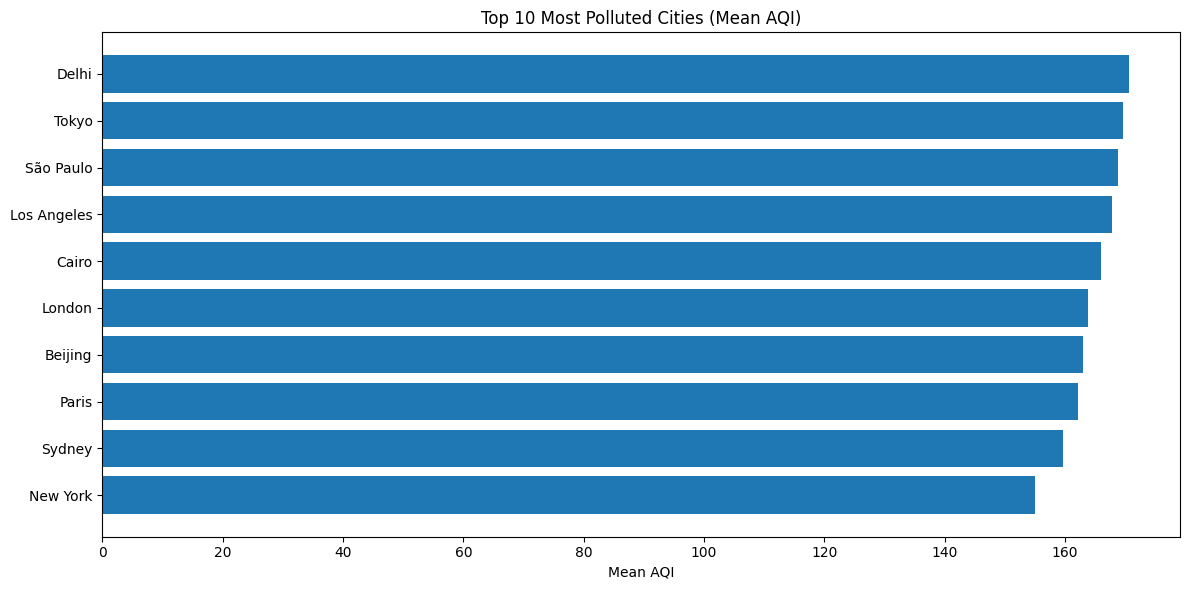

In [14]:
# Top 10 most polluted cities by mean AQI
if AQI_COL and CITY_COL:
    city_mean = df.groupby(CITY_COL, dropna=True)[AQI_COL].mean().dropna()
    if not city_mean.empty:
        top10 = city_mean.sort_values(ascending=False).head(10)[::-1]  # reverse for horizontal bar
        plt.figure()
        plt.barh(top10.index, top10.values)
        plt.title("Top 10 Most Polluted Cities (Mean AQI)")
        plt.xlabel("Mean AQI")
        plt.tight_layout()
        plt.show()
    else:
        print("No AQI values to compute city means.")
else:
    print("Skipping Top-10 plot (missing AQI/CITY).")


In [15]:
# Save a cleaned, analysis-ready CSV
save_cols = []
for c in [CITY_COL, COUNTRY_COL, DATE_COL, AQI_COL]:
    if c and c not in save_cols:
        save_cols.append(c)
for c in POLLUTANT_COLS:
    if c not in save_cols:
        save_cols.append(c)
for c in ["Year", "Month"]:
    if c in df.columns and c not in save_cols:
        save_cols.append(c)

clean = df[save_cols].copy() if save_cols else df.copy()
out_name = "aqi_cleaned_ready.csv"
clean.to_csv(out_name, index=False)
print(f"Saved: {out_name}")


Saved: aqi_cleaned_ready.csv
